In [1]:
def get_score_debug(self, fmap='', importance_type='weight'):
    """Get feature importance of each feature.
    Importance type can be defined as:
        'weight' - the number of times a feature is used to split the data across all trees.
        'gain' - the average gain of the feature when it is used in trees
        'cover' - the average coverage of the feature when it is used in trees
    Parameters
    ----------
    fmap: str (optional)
       The name of feature map file
    """

    if importance_type not in ['weight', 'gain', 'cover']:
        msg = "importance_type mismatch, got '{}', expected 'weight', 'gain', or 'cover'"
        raise ValueError(msg.format(importance_type))

    # if it's weight, then omap stores the number of missing values
    if importance_type == 'weight':
        # do a simpler tree dump to save time
        print ('what is fucking problem')
        trees = self.get_dump(fmap, with_stats=False) 
        # trees is list
        print ('trees',type(trees),len(trees),trees) 
        # len(trees)= the number of tress = n_estimators
        fmap = {}
        for tree in trees:
            print ('tree', tree)
            for line in tree.split('\n'):
                print ('line',line)
                # look for the opening square bracket
                arr = line.split('[')
                print('arr',arr, len(arr)) # 包含feature id and leaf score
                # if no opening bracket (leaf node), ignore this line
                if len(arr) == 1:
                    continue

                # extract feature name from string between []
                fid = arr[1].split(']')[0].split('<')[0]
                print ('feature id', fid)
                if fid not in fmap:
                    # if the feature hasn't been seen yet
                    fmap[fid] = 1
                else:
                    fmap[fid] += 1

        return fmap


In [2]:
# use feature importance for feature selection
import pandas as pd
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm
# load data
dataset = pd.read_csv('diabetes.csv')
# split data into X and y
X = dataset.values[:,0:8]
y = dataset.values[:,8]
print (X.shape)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model on all training data
n_estimators = 200
model = XGBClassifier(n_estimators = n_estimators)
model.fit(X_train, y_train)
# model
print ('model', model)
print('Is xgboost.core.Booster object ',model.get_booster())
importance = model.get_booster().get_score()
print ('feature importance',importance)
importance_debug = get_score_debug(model.get_booster())
print ('feature importance_debug',importance_debug)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

(768, 8)
model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Is xgboost.core.Booster object  <xgboost.core.Booster object at 0x108ec65c0>
feature importance {'f1': 217, 'f7': 197, 'f5': 182, 'f4': 91, 'f6': 177, 'f3': 100, 'f0': 85, 'f2': 115}
what is fucking problem
trees <class 'list'> 200 ['0:[f1<127.5] yes=1,no=2,missing=1\n\t1:[f7<28.5] yes=3,no=4,missing=3\n\t\t3:[f5<30.95] yes=7,no=8,missing=7\n\t\t\t7:leaf=-0.185586\n\t\t\t8:leaf=-0.128889\n\t\t4:[f5<26.35] yes=9,no=10,missing=9\n\t\t\t9:leaf=-0.173333\n\t\t\t10:leaf=-0.0324786\n\t2:[f5<28.15] yes=5,no=6,missing=5\n\t\t5:[f1<145.5] yes=11,no=12,missing=11\n\t\t\t11:leaf=-0.147826\n\t\t\t12:le

tree 0:[f1<101.5] yes=1,no=2,missing=1
	1:[f7<25.5] yes=3,no=4,missing=3
		3:leaf=-0.109632
		4:[f3<21.5] yes=7,no=8,missing=7
			7:leaf=-0.0760654
			8:leaf=-0.00462231
	2:[f7<24.5] yes=5,no=6,missing=5
		5:[f4<73] yes=9,no=10,missing=9
			9:leaf=-0.00214481
			10:leaf=-0.0891078
		6:[f6<0.71] yes=11,no=12,missing=11
			11:leaf=0.00151188
			12:leaf=0.0797677

line 0:[f1<101.5] yes=1,no=2,missing=1
arr ['0:', 'f1<101.5] yes=1,no=2,missing=1'] 2
feature id f1
line 	1:[f7<25.5] yes=3,no=4,missing=3
arr ['\t1:', 'f7<25.5] yes=3,no=4,missing=3'] 2
feature id f7
line 		3:leaf=-0.109632
arr ['\t\t3:leaf=-0.109632'] 1
line 		4:[f3<21.5] yes=7,no=8,missing=7
arr ['\t\t4:', 'f3<21.5] yes=7,no=8,missing=7'] 2
feature id f3
line 			7:leaf=-0.0760654
arr ['\t\t\t7:leaf=-0.0760654'] 1
line 			8:leaf=-0.00462231
arr ['\t\t\t8:leaf=-0.00462231'] 1
line 	2:[f7<24.5] yes=5,no=6,missing=5
arr ['\t2:', 'f7<24.5] yes=5,no=6,missing=5'] 2
feature id f7
line 		5:[f4<73] yes=9,no=10,missing=9
arr ['\t\t5:',

feature id f7
line 			9:leaf=-0.0849965
arr ['\t\t\t9:leaf=-0.0849965'] 1
line 			10:leaf=0.0656191
arr ['\t\t\t10:leaf=0.0656191'] 1
line 	2:[f3<16.5] yes=5,no=6,missing=5
arr ['\t2:', 'f3<16.5] yes=5,no=6,missing=5'] 2
feature id f3
line 		5:[f1<182.5] yes=11,no=12,missing=11
arr ['\t\t5:', 'f1<182.5] yes=11,no=12,missing=11'] 2
feature id f1
line 			11:leaf=0.023206
arr ['\t\t\t11:leaf=0.023206'] 1
line 			12:leaf=-0.0630906
arr ['\t\t\t12:leaf=-0.0630906'] 1
line 		6:[f4<80] yes=13,no=14,missing=13
arr ['\t\t6:', 'f4<80] yes=13,no=14,missing=13'] 2
feature id f4
line 			13:leaf=0.00975331
arr ['\t\t\t13:leaf=0.00975331'] 1
line 			14:leaf=0.0917446
arr ['\t\t\t14:leaf=0.0917446'] 1
line 
arr [''] 1
tree 0:[f5<22.8] yes=1,no=2,missing=1
	1:leaf=-0.0676852
	2:[f2<15] yes=3,no=4,missing=3
		3:[f1<130] yes=5,no=6,missing=5
			5:leaf=0.0106574
			6:leaf=0.0827126
		4:[f6<0.501] yes=7,no=8,missing=7
			7:leaf=-0.0115484
			8:leaf=0.0168757

line 0:[f5<22.8] yes=1,no=2,missing=1
arr ['0:'

feature id f5
line 			9:leaf=-0.0843349
arr ['\t\t\t9:leaf=-0.0843349'] 1
line 			10:leaf=-0.01429
arr ['\t\t\t10:leaf=-0.01429'] 1
line 	2:[f4<159] yes=5,no=6,missing=5
arr ['\t2:', 'f4<159] yes=5,no=6,missing=5'] 2
feature id f4
line 		5:[f4<26] yes=11,no=12,missing=11
arr ['\t\t5:', 'f4<26] yes=11,no=12,missing=11'] 2
feature id f4
line 			11:leaf=0.0106799
arr ['\t\t\t11:leaf=0.0106799'] 1
line 			12:leaf=-0.026045
arr ['\t\t\t12:leaf=-0.026045'] 1
line 		6:[f6<0.646] yes=13,no=14,missing=13
arr ['\t\t6:', 'f6<0.646] yes=13,no=14,missing=13'] 2
feature id f6
line 			13:leaf=0.00811832
arr ['\t\t\t13:leaf=0.00811832'] 1
line 			14:leaf=0.07434
arr ['\t\t\t14:leaf=0.07434'] 1
line 
arr [''] 1
tree 0:[f2<97] yes=1,no=2,missing=1
	1:[f2<87] yes=3,no=4,missing=3
		3:[f4<48.5] yes=5,no=6,missing=5
			5:leaf=0.0142359
			6:leaf=-0.0102718
		4:[f5<43] yes=7,no=8,missing=7
			7:leaf=-0.0647345
			8:leaf=0.0173308
	2:leaf=0.0467793

line 0:[f2<97] yes=1,no=2,missing=1
arr ['0:', 'f2<97] yes=

arr ['\t2:', 'f2<79] yes=5,no=6,missing=5'] 2
feature id f2
line 		5:[f1<125.5] yes=9,no=10,missing=9
arr ['\t\t5:', 'f1<125.5] yes=9,no=10,missing=9'] 2
feature id f1
line 			9:leaf=-0.0711619
arr ['\t\t\t9:leaf=-0.0711619'] 1
line 			10:leaf=0.0249393
arr ['\t\t\t10:leaf=0.0249393'] 1
line 		6:[f0<4.5] yes=11,no=12,missing=11
arr ['\t\t6:', 'f0<4.5] yes=11,no=12,missing=11'] 2
feature id f0
line 			11:leaf=0.0236344
arr ['\t\t\t11:leaf=0.0236344'] 1
line 			12:leaf=0.0878683
arr ['\t\t\t12:leaf=0.0878683'] 1
line 
arr [''] 1
tree 0:[f3<44.5] yes=1,no=2,missing=1
	1:[f6<0.5895] yes=3,no=4,missing=3
		3:[f6<0.501] yes=7,no=8,missing=7
			7:leaf=-0.00157509
			8:leaf=0.0491309
		4:[f6<0.641] yes=9,no=10,missing=9
			9:leaf=-0.08758
			10:leaf=-0.00954855
	2:[f6<0.427] yes=5,no=6,missing=5
		5:leaf=-0.0413955
		6:leaf=0.0892693

line 0:[f3<44.5] yes=1,no=2,missing=1
arr ['0:', 'f3<44.5] yes=1,no=2,missing=1'] 2
feature id f3
line 	1:[f6<0.5895] yes=3,no=4,missing=3
arr ['\t1:', 'f6<0.589

arr ['\t\t5:', 'f2<79] yes=11,no=12,missing=11'] 2
feature id f2
line 			11:leaf=-0.00598191
arr ['\t\t\t11:leaf=-0.00598191'] 1
line 			12:leaf=0.0208908
arr ['\t\t\t12:leaf=0.0208908'] 1
line 		6:[f2<97] yes=13,no=14,missing=13
arr ['\t\t6:', 'f2<97] yes=13,no=14,missing=13'] 2
feature id f2
line 			13:leaf=-0.0484736
arr ['\t\t\t13:leaf=-0.0484736'] 1
line 			14:leaf=0.0177083
arr ['\t\t\t14:leaf=0.0177083'] 1
line 
arr [''] 1
tree 0:[f1<165.5] yes=1,no=2,missing=1
	1:[f4<224] yes=3,no=4,missing=3
		3:[f6<0.2445] yes=7,no=8,missing=7
			7:leaf=-0.0156952
			8:leaf=0.00626718
		4:[f6<0.2475] yes=9,no=10,missing=9
			9:leaf=0.018122
			10:leaf=-0.0545937
	2:[f3<25.5] yes=5,no=6,missing=5
		5:[f6<0.327] yes=11,no=12,missing=11
			11:leaf=-0.0482445
			12:leaf=0.0226727
		6:leaf=0.0604806

line 0:[f1<165.5] yes=1,no=2,missing=1
arr ['0:', 'f1<165.5] yes=1,no=2,missing=1'] 2
feature id f1
line 	1:[f4<224] yes=3,no=4,missing=3
arr ['\t1:', 'f4<224] yes=3,no=4,missing=3'] 2
feature id f4
l

Thresh=0.078, n=7, Accuracy: 76.38%
Thresh=0.086, n=6, Accuracy: 77.56%
Thresh=0.099, n=5, Accuracy: 76.38%
Thresh=0.152, n=4, Accuracy: 76.38%
Thresh=0.156, n=3, Accuracy: 74.80%
Thresh=0.169, n=2, Accuracy: 71.65%
Thresh=0.186, n=1, Accuracy: 70.08%


In [3]:
model.feature_importances_

array([ 0.07302406,  0.18642612,  0.09879725,  0.08591066,  0.0781787 ,
        0.15635739,  0.15206185,  0.16924399], dtype=float32)

# Feature Selection with XGBoost Feature Importance Scores


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import sort
from sklearn.feature_selection import SelectFromModel # class

'''

Operation procedures:
1. using the whole entire dataset to train a base model
2. Also, to get sorted feature importance: 從最小的到最大的feeding into selection
3. Create a SelectFromModel instance
4. Using method of instance transfrom to reduce X to the selected features.
5. Creat a new classifier trained from the selected subset of features
6. evaluate the classifier
'''

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model on all training data
base_model = XGBClassifier()
base_model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = base_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(base_model.feature_importances_)
# core: essentially allowing us to test each subset of features by importance, 
# starting with all features and ending with a subset with the most important feature.
thresholds
for thresh in thresholds:
    # thresh becomes larger
    #
    # select features using threshold
    selection = SelectFromModel(base_model, threshold=thresh, prefit=True)
    '''
    prefit: Whether a pre-fit model is expected to be passed into the constructor directly or not. 
    threshold: The threshold value to use for feature selection. Features whose importance is greater or equal are kept 
    while the others are discarded. 
 
    '''
    
    # selection : SelectFromModel instance
    
    select_X_train = selection.transform(X_train) # Reduce X to the selected features.
    select_X_test = selection.transform(X_test) 
    #print('select_X_train', select_X_train.shape)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    '''
    It may be a more useful strategy on a larger dataset and using cross validation as the model evaluation scheme
    '''
    print("Thresh={}, n= {}, Accuracy: {}".format(thresh, select_X_train.shape[1], accuracy*100.0))


Accuracy: 77.95%
Thresh=0.07094594836235046, n= 8, Accuracy: 77.95275590551181
Thresh=0.07263513654470444, n= 7, Accuracy: 76.37795275590551
Thresh=0.08445946127176285, n= 6, Accuracy: 77.55905511811024
Thresh=0.08952702581882477, n= 5, Accuracy: 76.37795275590551
Thresh=0.12837837636470795, n= 4, Accuracy: 76.37795275590551
Thresh=0.16047297418117523, n= 3, Accuracy: 74.80314960629921
Thresh=0.18581080436706543, n= 2, Accuracy: 71.65354330708661
Thresh=0.20777027308940887, n= 1, Accuracy: 63.77952755905512


In [5]:
from tqdm import tqdm
from glob import glob
def read_multiple_csv(path, col = None):

    # glob(path+'/*'): return a list, which consist of each files in path

    if col is None:
        df = pd.concat([pd.read_csv(f) for f in tqdm(sorted(glob(path+'/*')))])
    else:
        df = pd.concat([pd.read_csv(f)[col] for f in tqdm(sorted(glob(path+'/*')))])
    return df
def load_pred_feature(name, keep_all = False):
    
    if keep_all == False:
        #==============================================================================
        print('keep top imp')
        #==============================================================================
        col = keep_top_item()
        if name=='test':
            col.remove('is_churn') # feature中沒有is_churn
        df = read_multiple_csv('../feature/{}/all'.format(name), col)
        #df = read_multiple_csv('../feature/{}/all_sampling_for_developing'.format(name).format(name), col)
    else:
        #path = '../feature/{}/all_sampling_for_developing'.format(name)
        df = read_multiple_csv('../feature/{}/all'.format(name)) 
    
    print('{}.shape:{}\n'.format(name, df.shape))
    
    return df
def split_build_valid(valid_size = 0.05):
    # train/val split by user
    train_user['is_valid'] = np.random.choice([0,1], size=len(train_user), 
                                              p=[1-valid_size, valid_size]) # randomly pick someone as validation user
    # is_valid: 1 if the user is validating user else 0
    valid_n = train_user['is_valid'].sum()
    build_n = (train_user.shape[0] - valid_n)
    print('build user:{}, valid user:{}'.format(build_n, valid_n))
    valid_user = train_user[train_user['is_valid']==1].msno
    is_valid = X_train.msno.isin(valid_user)
    # to create the XGBoost matrices that will be used to train the model using XGBoost. 
    x_train = X_train[~is_valid].drop('msno', axis=1)
    y_train = Y_train[~is_valid]
    x_val = X_train[is_valid].drop('msno', axis=1)
    y_val = Y_train[is_valid]
    print('FINAL SHAPE')
    print('x_train.shape:{0}'.format(x_train.shape))
    print('x_val.shape:{0}'.format(x_val.shape))

    return x_train.values[:,7:10], y_train.values, x_val.values[:,7:10], y_val.values

In [6]:
#==============================================================================
# prepare
#==============================================================================
train = pd.concat([load_pred_feature('trainW-0', keep_all = True),
                   # utils.load_pred_feature('trainW-1'),
                   # utils.load_pred_feature('trainW-2'),
                   ], ignore_index=True)



100%|██████████| 20/20 [01:48<00:00,  5.43s/it]


trainW-0.shape:(881896, 653)



In [7]:
train = train.sample(n = 10000)

In [8]:
train.is_churn.describe() 

count    10000.000000
mean         0.059000
std          0.235636
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_churn, dtype: float64

In [9]:
model = XGBClassifier(objective = 'binary:logistic',
                      max_depth = 150, learning_rate = 0.1, n_estimators = 100
                      )
model.fit(train[train.columns.tolist()[2:]], train['is_churn'], 
          eval_metric ='logloss' ,eval_set = [(train[train.columns.tolist()[2:]],train['is_churn'])],
          early_stopping_rounds = 10) 
# # model
# print ('model', model)
# 有問題n_estimators不能超過105?????
# print('Is xgboost.core.Booster object ',model.get_booster())
# importance_debug = get_score_debug(model.get_booster())
# print ('feature importance_debug',importance_debug)

[0]	validation_0-logloss:0.608733
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.539901
[2]	validation_0-logloss:0.482198
[3]	validation_0-logloss:0.433244
[4]	validation_0-logloss:0.391302
[5]	validation_0-logloss:0.354581
[6]	validation_0-logloss:0.322721
[7]	validation_0-logloss:0.294949
[8]	validation_0-logloss:0.269995
[9]	validation_0-logloss:0.247377
[10]	validation_0-logloss:0.227722
[11]	validation_0-logloss:0.209933
[12]	validation_0-logloss:0.193983
[13]	validation_0-logloss:0.179523
[14]	validation_0-logloss:0.166296
[15]	validation_0-logloss:0.154265
[16]	validation_0-logloss:0.143477
[17]	validation_0-logloss:0.133575
[18]	validation_0-logloss:0.12463
[19]	validation_0-logloss:0.116407
[20]	validation_0-logloss:0.108901
[21]	validation_0-logloss:0.101836
[22]	validation_0-logloss:0.095596
[23]	validation_0-logloss:0.089818
[24]	validation_0-logloss:0.084415
[25]	validation_0-logloss:0.079511
[26]	validation_0-logloss:0.07497

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=150, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# importance type

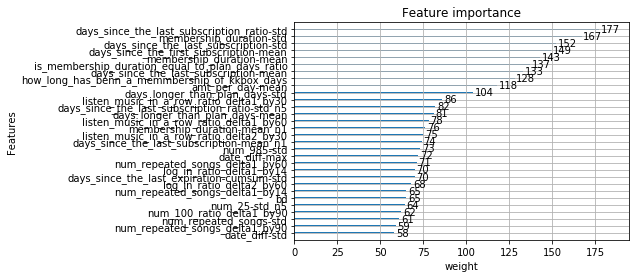

In [41]:
'''
Importance type can be defined as:
        'weight' - the number of times a feature is used to split the data across all trees.
        'gain' - the average gain of the feature when it is used in trees
        'cover' - the average coverage of the feature when it is used in trees
'''
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plot_importance(model, max_num_features = 30, importance_type='weight', xlabel='weight')
pyplot.show()

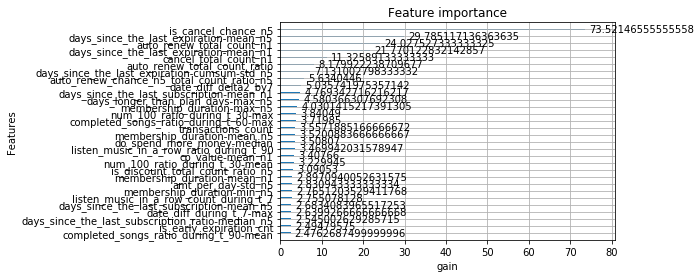

In [18]:
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plot_importance(model, max_num_features = 30, importance_type='gain', xlabel='gain')
pyplot.show()

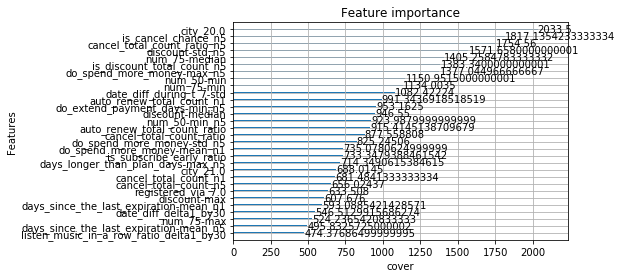

In [19]:
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plot_importance(model, max_num_features = 30, importance_type='cover', xlabel='cover')
pyplot.show()

In [36]:
import numpy as np
def split_build_valid(valid_size = 0.05):
    # train/val split by user
    train_user['is_valid'] = np.random.choice([0,1], size=len(train_user), 
                                              p=[1-valid_size, valid_size]) # randomly pick someone as validation user
    # is_valid: 1 if the user is validating user else 0
    valid_n = train_user['is_valid'].sum()
    build_n = (train_user.shape[0] - valid_n)
    print('build user:{}, valid user:{}'.format(build_n, valid_n))
    valid_user = train_user[train_user['is_valid']==1].msno
    is_valid = X_train.msno.isin(valid_user)
    # to create the XGBoost matrices that will be used to train the model using XGBoost. 
    x_train = X_train[~is_valid].drop('msno', axis=1)
    y_train = Y_train[~is_valid]
    x_val = X_train[is_valid].drop('msno', axis=1)
    y_val = Y_train[is_valid]
    print('FINAL SHAPE')
    print('x_train.shape:{0}'.format(x_train.shape))
    print('x_val.shape:{0}'.format(x_val.shape))

    return x_train, y_train, x_val, y_val

Y_train = train['is_churn'] 
X_train = train.drop('is_churn', axis=1)
#==============================================================================
# SPLIT!
print(' train/val splitting by user')
#==============================================================================
train_user = X_train[['msno']].drop_duplicates()

 train/val splitting by user


In [58]:
base_model = model
# Fit model using each importance as a threshold
thresholds = sort(base_model.feature_importances_).tolist()
# core: essentially allowing us to test each subset of features by importance, 
# starting with all features and ending with a subset with the most important feature.


In [57]:
for thresh in thresholds[::100]:
    print (thresh)

0.0
0.0
0.00017969451437238604
0.0006289308075793087
0.001347708865068853
0.0024258759804069996
0.004402515944093466


In [62]:
acc_num_feature_plot = []
for thresh in thresholds[::100]: # a[start:end:step] # start through not past end, by step
    # thresh becomes larger
    x_train, y_train, x_val, y_val = split_build_valid(valid_size = 0.05)
    # selection : SelectFromModel instance
    selection = SelectFromModel(base_model, threshold=thresh, prefit=True)
    '''
    prefit: Whether a pre-fit model is expected to be passed into the constructor directly or not. 
    threshold: The threshold value to use for feature selection. Features whose importance is greater or equal are kept 
    while the others are discarded. 
 
    '''
    # select features using threshold
    select_X_train = selection.transform(x_train) # Reduce X to the selected features.
    select_X_test = selection.transform(x_val) 
    # train model
    selection_model = XGBClassifier(seed = 72) # fixed seed
    selection_model.fit(select_X_train, y_train)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_val, predictions)
    acc_num_feature_plot.append((select_X_train.shape[1],accuracy))
    '''
    It may be a more useful strategy on a larger dataset and using cross validation as the model evaluation scheme
    '''
    print("Thresh={}, n= {}, Accuracy: {}".format(thresh, select_X_train.shape[1], accuracy*100.0))


build user:9536, valid user:464
FINAL SHAPE
x_train.shape:(9536, 651)
x_val.shape:(464, 651)
Thresh=0.0, n= 651, Accuracy: 93.10344827586206
build user:9499, valid user:501
FINAL SHAPE
x_train.shape:(9499, 651)
x_val.shape:(501, 651)
Thresh=0.0, n= 651, Accuracy: 94.2115768463074
build user:9496, valid user:504
FINAL SHAPE
x_train.shape:(9496, 651)
x_val.shape:(504, 651)
Thresh=0.00017969451437238604, n= 455, Accuracy: 96.23015873015873
build user:9515, valid user:485
FINAL SHAPE
x_train.shape:(9515, 651)
x_val.shape:(485, 651)
Thresh=0.0006289308075793087, n= 355, Accuracy: 95.05154639175257
build user:9501, valid user:499
FINAL SHAPE
x_train.shape:(9501, 651)
x_val.shape:(499, 651)
Thresh=0.001347708865068853, n= 260, Accuracy: 96.59318637274549
build user:9486, valid user:514
FINAL SHAPE
x_train.shape:(9486, 651)
x_val.shape:(514, 651)
Thresh=0.0024258759804069996, n= 152, Accuracy: 96.10894941634241
build user:9526, valid user:474
FINAL SHAPE
x_train.shape:(9526, 651)
x_val.shape:(

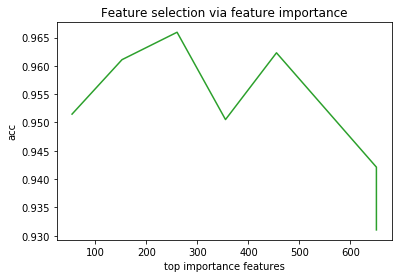

In [70]:
import matplotlib.pyplot as plt
x = [p[0] for p in acc_num_feature_plot]
y = [p[1] for p in acc_num_feature_plot]
plt.plot(x,y)
plt.title('Feature selection via feature importance')
plt.ylabel('acc')
plt.xlabel('top importance features')
plt.show()
# why we need feature selection
# 1. to filter the irrelevant feature improving accuracy
# 2. reducing # features increses speed of computation

866521    0
666745    0
360446    0
368693    0
806061    0
224638    0
617279    0
554580    0
629547    0
592962    0
390538    0
590508    0
335876    0
796011    0
551719    0
226554    0
683910    0
353021    0
60690     0
722651    0
875730    0
460629    0
320412    0
190099    1
443564    0
594963    0
127776    0
632297    0
479099    0
274055    0
         ..
879772    0
201978    0
716383    0
643399    0
683468    0
458196    0
419306    0
523767    0
306593    0
22195     1
576026    0
489322    0
315091    0
29751     1
449208    0
158138    0
745709    0
245938    0
227640    0
547915    0
378009    0
245461    0
644213    0
229566    0
866574    0
430919    0
278778    0
263518    0
777769    0
778446    0
Name: is_churn, Length: 474, dtype: int64

In [18]:
##########################################
#load dataset
##########################################
seed = 72
# load dataset
train_0 = load_pred_feature('trainW-0', keep_all = True)
train_1 = load_pred_feature('trainW-1', keep_all = True)
train_2 = load_pred_feature('trainW-2', keep_all = True)


  0%|          | 0/20 [00:00<?, ?it/s]

trainW-0.shape:(881896, 653)



  0%|          | 0/20 [00:00<?, ?it/s]

trainW-1.shape:(884309, 653)



100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


trainW-2.shape:(905872, 653)



In [21]:
seed = 72
# make data augmentation having same label distribution with training set provided by the kkbox
per_churned_in_train_0 = train_0[['is_churn']].describe().ix['mean'][0] 
n_churned = train_1[train_1.is_churn == 0].shape[0] * per_churned_in_train_0
print('per_churned_in_train_0', per_churned_in_train_0)
print('n_churned', int(n_churned))
train_1 = pd.concat([train_1[train_1.is_churn == 0],
                train_1[train_1.is_churn == 1].sample(n = int(n_churned), random_state = seed)
               ], ignore_index=True)
per_churned_in_train_1 = train_1[['is_churn']].describe().ix['mean'][0] 
print('per_churned_in_train_1', per_churned_in_train_1)
train_2 = pd.concat([train_2[train_2.is_churn == 0],
                train_2[train_2.is_churn == 1].sample(n = int(n_churned), random_state = seed)
               ], ignore_index=True)
per_churned_in_train_2 = train_1[['is_churn']].describe().ix['mean'][0] 
print('per_churned_in_train_2', per_churned_in_train_2)
train = pd.concat([train_0, train_1, train_2], ignore_index=True)
#del train_0, train_1, train_2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


per_churned_in_train_0 0.0587484238504
n_churned 10042


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


per_churned_in_train_1 0.0554877139084


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


per_churned_in_train_2 0.0554877139084


In [ ]:
import gc
gc.collect()

#==============================================================================
# prepare training data
#==============================================================================
Y_train = train['is_churn'] 
X_train = train.drop('is_churn', axis=1)


# X_train = X_train.sample(n = 1000)
# Y_train = Y_train.sample(n = 1000)
# print ('distribution', Y_train.describe())
# del train

print ('prepartion of training set is done')


In [23]:
import numpy as np
def split_build_valid(valid_size = 0.05):
    # train/val split by user
    train_user['is_valid'] = np.random.choice([0,1], size=len(train_user), 
                                              p=[1-valid_size, valid_size]) # randomly pick someone as validation user
    # is_valid: 1 if the user is validating user else 0
    valid_n = train_user['is_valid'].sum()
    build_n = (train_user.shape[0] - valid_n)
    print('build user:{}, valid user:{}'.format(build_n, valid_n))
    valid_user = train_user[train_user['is_valid']==1].msno
    is_valid = X_train.msno.isin(valid_user)
    # to create the XGBoost matrices that will be used to train the model using XGBoost. 
    x_train = X_train[~is_valid].drop('msno', axis=1)
    y_train = Y_train[~is_valid]
    x_val = X_train[is_valid].drop('msno', axis=1)
    y_val = Y_train[is_valid]
    print('FINAL SHAPE')
    print('x_train.shape:{0}'.format(x_train.shape))
    print('x_val.shape:{0}'.format(x_val.shape))

    return x_train, y_train, x_val, y_val

train_user = X_train[['msno']].drop_duplicates()
x_train, y_train, x_val, y_val = split_build_valid(valid_size = 0.05)
##########################################
# base_model for getting feature importance as thereshold
##########################################
import time
s = time.time()
base_model = XGBClassifier(objective = 'binary:logistic',
                      )
model.fit(x_train, y_train, 
          eval_metric ='logloss' ,eval_set = [(x_val, y_val)],
          early_stopping_rounds = 10) 

# Fit model using each importance as a threshold
thresholds = sort(base_model.feature_importances_).tolist()# thresh becomes larger
e = time.time()
print ('It tooks',e-s, 'secs')

build user:864689, valid user:45783
FINAL SHAPE
x_train.shape:(1073967, 651)
x_val.shape:(56999, 651)
[0]	validation_0-logloss:0.616352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.553548
[2]	validation_0-logloss:0.501397
[3]	validation_0-logloss:0.456433


KeyboardInterrupt: 